# Sentiment Analysis with an RNN

será implementado uma rede neural recorrente cujo objetivo é realizar uma análise de sentimento.
Base de dados: Será usado um conjunto de dados de resenhas de filmes, acompanhados de seus rótulos (se positivo ou negativo)

As palavras serão passadas por uma camada de incorporação. Há dezenas de milhares de palavras, portanto, deve haver uma representação mais eficiente para os dados de entrada do que vetores codificados por one-hot. O uso dessa representação do espaço vetorial nos permitirá ter uma representação distribuída e contínua de nossas palavras do vocabulário.

Da camada de incorporação as novas representações, agora vetoriais,  serão passadas para as células LSTM. Elas adicionarão conexões recorrentes à rede para que possamos incluir informações sobre a sequência de palavras nos dados. Finalmente, as células LSTM irão para uma camada de saída com uma função de ativação sigmoide. Será usado sigmoide porque precisa-se prever se o texto tem sentimento positivo ou negativo. A camada de saída será de apenas uma única unidade.

Nos importaremos apenas com ultima saída sigmoide. Calcularemos o custo a partir da saída da última etapa e do rótulo de treinamento.

#### Análise exploratória dos dados:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
print(tf.__version__)

2.5.0-dev20210204


In [2]:
with open('reviews.txt', 'r') as f:
    reviews = f.read()
with open('labels.txt', 'r') as f:
    labels = f.read()

### Remoção Stopwords 
#### - Compilar essa célula caso queira a remoção de stop words, caso não, vá para célula C/Stopwords

In [4]:
from string import punctuation
from nltk.corpus import stopwords

linha = reviews.split('\n')
stop_words = set(stopwords.words('english') + list(punctuation))
sentences=[]

for c in linha:
    split_words = c.split()
    clean_text = ' '.join([i for i in split_words if i not in stop_words])
    sentences.append(clean_text)

## BOW - Arvore Decisão e Floresta Randômica

#### Abaixo, o pré-processamento para os algoritmos AD e FD. Técnica utilizada: BOW

In [94]:
from sklearn.feature_extraction.text import CountVectorizer

bow_vectorizer = CountVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')

# bag-of-words feature matrix
bow = bow_vectorizer.fit_transform(linha)

df_bow = pd.DataFrame(bow.todense())

df_bow

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
3,0,0,0,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
24996,0,1,0,0,0,0,0,1,0,0,...,0,0,0,3,0,0,0,0,0,0
24997,0,0,0,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,2,0
24998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### preparando o arquivo de rótulos

In [95]:
import numpy as np
import collections
labels = labels.split('\n')
labels = np.array([1 if each == 'positive' else 0 for each in labels])
print(collections.Counter(labels))

Counter({1: 12500, 0: 12500})


#### dividindo os dados em treinamento, validação e teste

In [96]:
split_frac = 0.8 # geralmente usado 0,8 ou 0,9 de split fraction
split_idx = int(len(df_bow)*0.8) # len(features) = 8660, split_idx = 6928

train_x, val_x = df_bow[:split_idx], df_bow[split_idx:]
train_y, val_y = labels[:split_idx], labels[split_idx:]

test_idx = int(len(val_x)*0.5) #len(val_x) = 1732, #test_idx = 866
val_x, test_x = val_x[:test_idx], val_x[test_idx:]
val_y, test_y = val_y[:test_idx], val_y[test_idx:]

print("\t\t\tFeature Shapes:")
print("Train set: \t\t{}".format(train_x.shape), 
      "\nValidation set: \t{}".format(val_x.shape),
      "\nTest set: \t\t{}".format(test_x.shape))

			Feature Shapes:
Train set: 		(20000, 1000) 
Validation set: 	(2500, 1000) 
Test set: 		(2500, 1000)


### Treinando os modelos comparativos

#### o algoritmo de regressão logarítimica apresentou bons resultados, porém não foi utilizado no trabalho

In [97]:
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
Log_Reg = LogisticRegression(random_state=0,solver='lbfgs')

Log_Reg.fit(train_x,train_y)
prediction_bow = Log_Reg.predict_proba(val_x)
prediction_bow

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


array([[0.07082008, 0.92917992],
       [0.95727188, 0.04272812],
       [0.00647828, 0.99352172],
       ...,
       [0.95923055, 0.04076945],
       [0.38883935, 0.61116065],
       [0.9407031 , 0.0592969 ]])

In [12]:
# if prediction is greater than or equal to 0.3 than 1 else 0
# Where 0 is for positive sentiment tweets and 1 for negative sentiment tweets
prediction_int = prediction_bow[:,1]>=0.3

# converting the results to integer type
prediction_int = prediction_int.astype(np.int)
prediction_int

# calculating f1 score
log_bow = f1_score(val_y, prediction_int)

log_bow

0.8542825361512792

### Árvore de decisão

#### Métricas com dados de treino

In [106]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
dct = DecisionTreeClassifier(criterion='entropy',random_state=1,max_depth=15)
dct.fit(train_x,train_y)
dct_bow = dct.predict(train_x)
print('Accuracy of',accuracy_score(dct_bow,train_y)*100)


Accuracy of 79.99000000000001


In [107]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

print(classification_report(train_y,dct_bow))

              precision    recall  f1-score   support

           0       0.86      0.72      0.78     10000
           1       0.76      0.88      0.82     10000

    accuracy                           0.80     20000
   macro avg       0.81      0.80      0.80     20000
weighted avg       0.81      0.80      0.80     20000



#### Métricas com dados de validação

In [108]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
dct = DecisionTreeClassifier(criterion='entropy',random_state=1,max_depth=15)
dct.fit(train_x,train_y)
dct_bow = dct.predict(val_x)
print('Accuracy of',accuracy_score(dct_bow,val_y)*100)


Accuracy of 73.36


In [109]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

print(classification_report(val_y,dct_bow))

              precision    recall  f1-score   support

           0       0.77      0.66      0.71      1250
           1       0.70      0.81      0.75      1250

    accuracy                           0.73      2500
   macro avg       0.74      0.73      0.73      2500
weighted avg       0.74      0.73      0.73      2500



### Floresta Randômica

#### Métricas com dados de treino

In [102]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(criterion='entropy', random_state=1)
rfc.fit(train_x,train_y)
rfc_bow = rfc.predict(train_x)
print('Accuracy of',accuracy_score(rfc_bow,train_y)*100)
#rfc_bow = rfc.predict_proba(val_x)
#rfc_bow

Accuracy of 100.0


In [103]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

print(classification_report(train_y,rfc_bow))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10000
           1       1.00      1.00      1.00     10000

    accuracy                           1.00     20000
   macro avg       1.00      1.00      1.00     20000
weighted avg       1.00      1.00      1.00     20000



#### Métricas com dados de validação

In [104]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(criterion='entropy', random_state=1)
rfc.fit(train_x,train_y)
rfc_bow = rfc.predict(val_x)
print('Accuracy of',accuracy_score(rfc_bow,val_y)*100)

Accuracy of 82.28


In [105]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

print(classification_report(val_y,rfc_bow))

              precision    recall  f1-score   support

           0       0.82      0.83      0.82      1250
           1       0.83      0.81      0.82      1250

    accuracy                           0.82      2500
   macro avg       0.82      0.82      0.82      2500
weighted avg       0.82      0.82      0.82      2500



### REDE Neural

#### Abaixo o pré-processamento para a Rede Neural. Foi feita uma comparação, mantendo as StopWords e as Retirando
#### Técnica utilizada: Dicionário e Word Embedding

### C/ Stopwords

In [79]:
#Tokenização
words_ints = []

for c in linha:
    words_split = c.split()
    for a in words_split:
        words_ints.append(''.join(a))

In [ ]:
#Definindo a frequência das palavras

def frequency(my_list): 

    # Creating an empty dictionary  
    freq = {} 
    for item in my_list: 
        if (item in freq): 
            freq[item] += 1
        else: 
            freq[item] = 1 
    return freq
    #for key, value in freq.items(): 
    #print (" % s : % d"%(key, value)) 

final_list = frequency(words_ints)   

In [ ]:
#Traduzindo o texto

from collections import Counter 
counts = final_list
#Counter({'bromwell': 8, 'high': 2161, 'cartoon': 545

vocab = sorted(counts, key=counts.get, reverse=True)

#['br', 'movie', 'film', 'one', 'time'

vocab_to_int = {palavra: ii for ii, palavra in enumerate(vocab, 1)}

#{'br':1, 'movie':2, 'film':3, 'one':4, 'time':5,

reviews_ints = []
    
for each in linha: # para cada linha do texto original
    each_words = each.split()
    reviews_ints.append([vocab_to_int[palavra] for palavra in each_words]) #adiciona à lista o número da palavra

In [ ]:
#analisando o tamanho dos vetores e definindo um tamanho padrão

from tqdm.notebook import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

lengths = [len(i) for i in tqdm(reviews_ints)]

length_as_series = pd.Series(lengths)
plt.title("Probability Density Function for text lengths")
plt.xlabel('text lenghts')


sns.distplot(length_as_series)



max_pad_length = length_as_series.quantile(0.8) #percentil 8
print(max_pad_length)

In [ ]:
#Padronizando os vetores 

seq_len = max_pad_length
features = np.zeros((len(linha), seq_len), dtype=int)
for i, row in enumerate(reviews_ints):
    features[i, -len(row):] = np.array(row)[:seq_len]


In [ ]:
#Divisão em treino, validação e teste

split_frac = 0.8 
split_idx = int(len(features)*0.8)

train_x, val_x = features[:split_idx], features[split_idx:]
train_y, val_y = labels[:split_idx], labels[split_idx:]

test_idx = int(len(val_x)*0.5) 
val_x, test_x = val_x[:test_idx], val_x[test_idx:]
val_y, test_y = val_y[:test_idx], val_y[test_idx:]

print("\t\t\tFeature Shapes:")
print("Train set: \t\t{}".format(train_x.shape), 
      "\nValidation set: \t{}".format(val_x.shape),
      "\nTest set: \t\t{}".format(test_x.shape))

In [18]:
#Arquitetura da Rede

embedding_dim = 64
n_words = len(vocab)
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(n_words+1, embedding_dim),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 64)          4730880   
_________________________________________________________________
global_average_pooling1d_2 ( (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 390       
_________________________________________________________________
dropout_2 (Dropout)          (None, 6)                 0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 7         
Total params: 4,731,277
Trainable params: 4,731,277
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#Compilando o modelo

from keras import backend as K
num_epochs = 10

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc',f1_m,precision_m, recall_m])

# fit the model
history = model.fit(train_x, train_y,
              batch_size=500, epochs=num_epochs,
              verbose=2,
              validation_data=(val_x, val_y))

# evaluate the model
#loss, accuracy, f1_score, precision, recall = model.evaluate(test_x, test_y, verbose=0)

### S/ Stopwords - Foram retiradas as palavras não necessárias para o entendimento do contexto, como artigos, preposições, etc

In [5]:
#Tokenização
words_ints = []

for c in sentences:
    words_split = c.split()
    for a in words_split:
        words_ints.append(''.join(a))

In [6]:
#Definindo a frequência das palavras

def frequency(my_list): 

    # Creating an empty dictionary  
    freq = {} 
    for item in my_list: 
        if (item in freq): 
            freq[item] += 1
        else: 
            freq[item] = 1 
    return freq
    #for key, value in freq.items(): 
    #print (" % s : % d"%(key, value)) 

final_list = frequency(words_ints)

In [7]:
#Traduzindo o texto

from collections import Counter 

counts = final_list
#Counter({'bromwell': 8, 'high': 2161, 'cartoon': 545

vocab = sorted(counts, key=counts.get, reverse=True) 

#['br', 'movie', 'film', 'one', 'time'

vocab_to_int = {palavra: ii for ii, palavra in enumerate(vocab, 1)}

#{'br':1, 'movie':2, 'film':3, 'one':4, 'time':5,

reviews_ints = []
    
for each in sentences: # para cada linha do texto original
    each_words = each.split()
    reviews_ints.append([vocab_to_int[palavra] for palavra in each_words]) #adiciona à lista o número da palavra
  

### Encoding the labels

Os rótulos são "positivos" ou "negativos". Para usar esses rótulos na rede, pode-se convertê-los em 0 e 1.


In [8]:
import numpy as np
import collections
labels = labels.split('\n')
labels = np.array([1 if each == 'positive' else 0 for each in labels])
print(collections.Counter(labels))


Counter({1: 12500, 0: 12500})


In [9]:
review_lens = Counter([len(x) for x in reviews_ints])

print("Zero-length reviews: {}".format(review_lens[0]))
print("Maximum review length: {}".format(max(review_lens)))

Zero-length reviews: 0
Maximum review length: 1442


In [9]:
# Filter out that review with 0 length
reviews_ints = [each for each in reviews_ints if len(each) > 0]

In [215]:
#!pip install tqdm

Tem-se uma revisão com comprimento zero além de o comprimento máximo da revisão serem muitos passos para a RNN. Será estabelecido o limite de 173 entradas. Para avaliações menores que 173, será preenchido com 0s. Para comentários maiores que esse limite, serão truncados nos primeiros 173 caracteres.


151.0


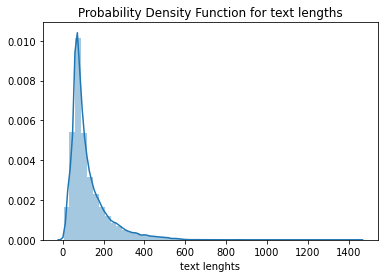

In [10]:
#analisando o tamanho dos vetores e definindo um tamanho padrão

from tqdm.notebook import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

lengths = [len(i) for i in tqdm(reviews_ints)]

length_as_series = pd.Series(lengths)
plt.title("Probability Density Function for text lengths")
plt.xlabel('text lenghts')


sns.distplot(length_as_series)



max_pad_length = length_as_series.quantile(0.75) #percentil 8
print(max_pad_length)

Será criado um array `features` que contém os dados que passaremos para a rede. Os dados virão de `review_ints`, pois a rede será alimentada pelos inteiros. Para comentários com menos de 200 palavras, bloco esquerdo será preenchido com 0s. Ou seja, se a revisão for `['melhor', 'filme', 'sempre']`, `[117, 18, 128]`, a linha será semelhante a `[0, 0, 0, .. ., 0, 117, 18, 128] `.


In [11]:
#Padronizando os vetores 

seq_len = 151
features = np.zeros((len(sentences), seq_len), dtype=int) #numpy.zeros(shape = 8660, dtype=int)
for i, row in enumerate(reviews_ints):
    features[i, -len(row):] = np.array(row)[:seq_len]


## Dados de treinamento, validação e teste
Geralmente usa-se 80% dos dados para treinamento. Os outros 20% divididos em teste e validação, 10% para cada.

Com treino, validação e e teste com frações respectivamente de 0.8, 0.1, 0.1, o resultado final deverá ser algo como:
```
                    Feature Shapes:
Train set: 		 (20000, 173) 
Validation set: 	(2500, 173) 
Test set: 		  (2500, 173)
```

In [12]:
#Divisão em treino, validação e teste

split_frac = 0.8 
split_idx = int(len(features)*0.8)

train_x, val_x = features[:split_idx], features[split_idx:]
train_y, val_y = labels[:split_idx], labels[split_idx:]

test_idx = int(len(val_x)*0.5) 
val_x, test_x = val_x[:test_idx], val_x[test_idx:]
val_y, test_y = val_y[:test_idx], val_y[test_idx:]

print("\t\t\tFeature Shapes:")
print("Train set: \t\t{}".format(train_x.shape), 
      "\nValidation set: \t{}".format(val_x.shape),
      "\nTest set: \t\t{}".format(test_x.shape))

			Feature Shapes:
Train set: 		(20000, 151) 
Validation set: 	(2500, 151) 
Test set: 		(2500, 151)


### Modelo RNN básico

In [48]:
#Arquitetura do modelo
#from keras.layers import Dropout
embedding_dim = 64
n_words = len(vocab)
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(n_words+1, embedding_dim),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_18 (Embedding)     (None, None, 64)          4730880   
_________________________________________________________________
global_average_pooling1d_7 ( (None, 64)                0         
_________________________________________________________________
dense_27 (Dense)             (None, 10)                650       
_________________________________________________________________
dropout_11 (Dropout)         (None, 10)                0         
_________________________________________________________________
dense_28 (Dense)             (None, 1)                 11        
Total params: 4,731,541
Trainable params: 4,731,541
Non-trainable params: 0
_________________________________________________________________


In [49]:
#Compilando o modelo

from keras import backend as K
num_epochs = 10

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# compile the model
#model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc',f1_m,precision_m, recall_m])
model.compile(optimizer='adam', loss='mse', metrics=['acc',f1_m,precision_m, recall_m])
# fit the model
history = model.fit(train_x, train_y,
              batch_size=500, epochs=num_epochs,
              verbose=2,
              validation_data=(val_x, val_y))

# evaluate the model
#loss, accuracy, f1_score, precision, recall = model.evaluate(test_x, test_y, verbose=0)

Epoch 1/10
40/40 - 5s - loss: 0.2485 - acc: 0.5749 - f1_m: 0.6312 - precision_m: 0.5552 - recall_m: 0.7491 - val_loss: 0.2458 - val_acc: 0.6684 - val_f1_m: 0.7473 - val_precision_m: 0.6045 - val_recall_m: 0.9792
Epoch 2/10
40/40 - 4s - loss: 0.2391 - acc: 0.7106 - f1_m: 0.7456 - precision_m: 0.6669 - recall_m: 0.8489 - val_loss: 0.2323 - val_acc: 0.7840 - val_f1_m: 0.8149 - val_precision_m: 0.7135 - val_recall_m: 0.9504
Epoch 3/10
40/40 - 4s - loss: 0.2166 - acc: 0.7687 - f1_m: 0.7874 - precision_m: 0.7297 - recall_m: 0.8574 - val_loss: 0.2055 - val_acc: 0.8348 - val_f1_m: 0.8480 - val_precision_m: 0.7857 - val_recall_m: 0.9216
Epoch 4/10
40/40 - 4s - loss: 0.1836 - acc: 0.8150 - f1_m: 0.8224 - precision_m: 0.7910 - recall_m: 0.8575 - val_loss: 0.1733 - val_acc: 0.8480 - val_f1_m: 0.8546 - val_precision_m: 0.8194 - val_recall_m: 0.8936
Epoch 5/10
40/40 - 4s - loss: 0.1501 - acc: 0.8499 - f1_m: 0.8526 - precision_m: 0.8377 - recall_m: 0.8690 - val_loss: 0.1470 - val_acc: 0.8560 - val_f1

### Modelo LSTM - KERAS

In [32]:
from tensorflow.keras.layers import LSTM
from keras.layers import Dropout

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(n_words+1, embedding_dim))
#model.add(LSTM(50, activation='relu', input_shape=(1, 1)))
model.add(Dropout(0.2))
model.add(LSTM(5, activation='relu', return_sequences=True, input_shape=(1, 1)))
model.add(LSTM(10, activation='relu'))
#model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, None, 64)          4730880   
_________________________________________________________________
dropout_2 (Dropout)          (None, None, 64)          0         
_________________________________________________________________
lstm_12 (LSTM)               (None, None, 5)           1400      
_________________________________________________________________
lstm_13 (LSTM)               (None, 10)                640       
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 11        
Total params: 4,732,931
Trainable params: 4,732,931
Non-trainable params: 0
_________________________________________________________________


In [29]:
#Compilando o modelo

from keras import backend as K
num_epochs = 10

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# compile the model
#model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc',f1_m,precision_m, recall_m])
model.compile(optimizer='adam', loss='mse', metrics=['acc',f1_m,precision_m, recall_m])
# fit the model
history = model.fit(train_x, train_y,
              batch_size=500, epochs=num_epochs,
              verbose=2,
              validation_data=(val_x, val_y))

# evaluate the model
#loss, accuracy, f1_score, precision, recall = model.evaluate(test_x, test_y, verbose=0)

Epoch 1/10
40/40 - 21s - loss: 0.2483 - acc: 0.6327 - f1_m: 0.5901 - precision_m: 0.6518 - recall_m: 0.6075 - val_loss: 0.2437 - val_acc: 0.7308 - val_f1_m: 0.7289 - val_precision_m: 0.7341 - val_recall_m: 0.7240
Epoch 2/10
40/40 - 14s - loss: 0.2040 - acc: 0.8054 - f1_m: 0.7959 - precision_m: 0.8338 - recall_m: 0.7678 - val_loss: 0.1406 - val_acc: 0.8168 - val_f1_m: 0.8294 - val_precision_m: 0.7757 - val_recall_m: 0.8912
Epoch 3/10
40/40 - 15s - loss: 0.0907 - acc: 0.8863 - f1_m: 0.8884 - precision_m: 0.8720 - recall_m: 0.9069 - val_loss: 0.1264 - val_acc: 0.8332 - val_f1_m: 0.8305 - val_precision_m: 0.8449 - val_recall_m: 0.8168
Epoch 4/10
40/40 - 14s - loss: 0.0613 - acc: 0.9298 - f1_m: 0.9294 - precision_m: 0.9294 - recall_m: 0.9315 - val_loss: 0.1295 - val_acc: 0.8224 - val_f1_m: 0.8188 - val_precision_m: 0.8354 - val_recall_m: 0.8032
Epoch 5/10
40/40 - 14s - loss: 0.0398 - acc: 0.9585 - f1_m: 0.9587 - precision_m: 0.9559 - recall_m: 0.9617 - val_loss: 0.1397 - val_acc: 0.8268 - v

In [147]:
#Utilizando dados de teste
loss, accuracy, f1_score, precision, recall = model.evaluate(test_x, test_y, verbose=2)

79/79 - 1s - loss: 0.1110 - acc: 0.8524 - f1_m: 0.8454 - precision_m: 0.8730 - recall_m: 0.8315


In [74]:
loss, accuracy, f1_score, precision, recall = model.evaluate(test_x, test_y, verbose=2)

79/79 - 1s - loss: 0.1104 - acc: 0.8544 - f1_m: 0.8471 - precision_m: 0.8736 - recall_m: 0.8339


### Teste Dropout

In [37]:
from tensorflow.keras.layers import LSTM
from keras.layers import Dropout

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(n_words+1, embedding_dim))
#model.add(LSTM(50, activation='relu', input_shape=(1, 1)))
model.add(Dropout(0.1))
model.add(LSTM(5, activation='relu', return_sequences=True, input_shape=(1, 1)))
model.add(LSTM(10, activation='relu'))
#model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, None, 64)          4730880   
_________________________________________________________________
dropout_5 (Dropout)          (None, None, 64)          0         
_________________________________________________________________
lstm_18 (LSTM)               (None, None, 5)           1400      
_________________________________________________________________
lstm_19 (LSTM)               (None, 10)                640       
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 11        
Total params: 4,732,931
Trainable params: 4,732,931
Non-trainable params: 0
_________________________________________________________________


In [38]:
#Compilando o modelo

from keras import backend as K
num_epochs = 10

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# compile the model
#model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc',f1_m,precision_m, recall_m])
model.compile(optimizer='adam', loss='mse', metrics=['acc',f1_m,precision_m, recall_m])
# fit the model
history = model.fit(train_x, train_y,
              batch_size=500, epochs=num_epochs,
              verbose=2,
              validation_data=(val_x, val_y))

# evaluate the model
#loss, accuracy, f1_score, precision, recall = model.evaluate(test_x, test_y, verbose=0)

Epoch 1/10
40/40 - 16s - loss: 0.2488 - acc: 0.6144 - f1_m: 0.5783 - precision_m: 0.6831 - recall_m: 0.5546 - val_loss: 0.2457 - val_acc: 0.6592 - val_f1_m: 0.5579 - val_precision_m: 0.7930 - val_recall_m: 0.4312
Epoch 2/10
40/40 - 12s - loss: 0.2116 - acc: 0.7328 - f1_m: 0.6715 - precision_m: 0.8473 - recall_m: 0.5867 - val_loss: 0.1491 - val_acc: 0.7992 - val_f1_m: 0.8031 - val_precision_m: 0.7879 - val_recall_m: 0.8192
Epoch 3/10
40/40 - 12s - loss: 0.1064 - acc: 0.8618 - f1_m: 0.8675 - precision_m: 0.8385 - recall_m: 0.9030 - val_loss: 0.1222 - val_acc: 0.8252 - val_f1_m: 0.8312 - val_precision_m: 0.8038 - val_recall_m: 0.8608
Epoch 4/10
40/40 - 12s - loss: 0.0614 - acc: 0.9247 - f1_m: 0.9257 - precision_m: 0.9124 - recall_m: 0.9399 - val_loss: 0.1229 - val_acc: 0.8276 - val_f1_m: 0.8320 - val_precision_m: 0.8112 - val_recall_m: 0.8544
Epoch 5/10
40/40 - 12s - loss: 0.0405 - acc: 0.9548 - f1_m: 0.9553 - precision_m: 0.9463 - recall_m: 0.9649 - val_loss: 0.1339 - val_acc: 0.8248 - v

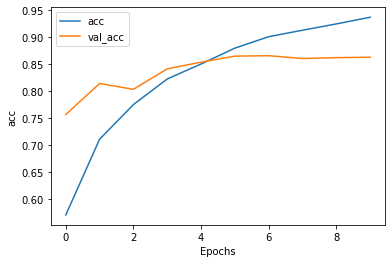

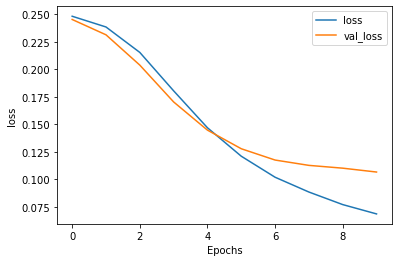

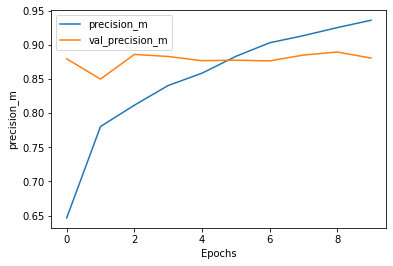

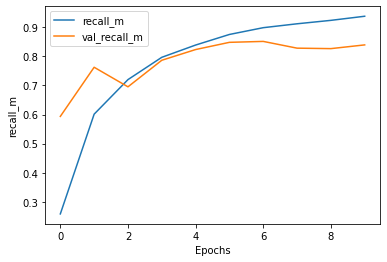

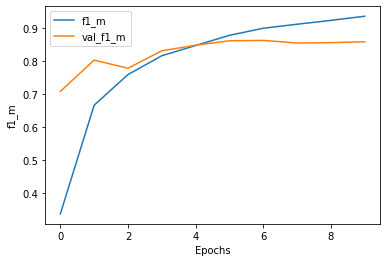

In [113]:
#Plotando os gráficos

import matplotlib.pyplot as plt


def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()
    
#plot_graphs(history, "accuracy")
plot_graphs(history, "acc")
plot_graphs(history, "loss")
plot_graphs(history, "precision_m")
plot_graphs(history, "recall_m")
plot_graphs(history, "f1_m")

## Escolha dos hiperparâmetros - Outro modo de criar uma Rede Neural

Primeiro, definindo os hiperparâmetros.

lstm_size: Número de unidades nas camadas ocultas nas células LSTM. Normalmente, quanto maior é o melhor desempenho. Os valores comuns são 128, 256, 512, etc.

lstm_layers: Número de camadas LSTM na rede. Será definido como 1 a princípio.

batch_size: o número de revisões para alimentar a rede em uma passagem de treinamento. Normalmente, isso deve ser definido o mais alto possível sem ficar sem memória.

learning_rate: taxa de aprendizagem

In [ ]:
lstm_size = 256
#lstm_layers = 1
batch_size = 500
learning_rate = 0.001

Para a própria rede, passaremos nossos vetores de revisão de 173 elementos. Cada lote será de vetores batch_size. Também será usado dropout na camada LSTM, então haverá um placeholder para a probabilidade de keep.


Criando os tensores `inputs_`,` labels_` e `keep_prob` usando` tf.placeholder`. `labels_` precisa ser bidimensional para funcionar com algumas funções posteriormente. Como `keep_prob` é um escalar (um tensor 0-dimensional), não deve-se fornecer um tamanho para` tf.placeholder`.

In [ ]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() #para conseguir usar tf.placeholder
n_words = len(vocab)

# Create the graph object
graph = tf.Graph()
# Add nodes to the graph
with graph.as_default():
    inputs_ = tf.placeholder(tf.int32, [None, None], name='inputs')
    labels_ = tf.placeholder(tf.int32, [None, None], name='labels')
    keep_prob = tf.placeholder(tf.float32, name='keep_prob')

### Embedding
Agora vamos adicionar uma camada de incorporação. Precisamos fazer isso porque existem milhares de palavras em nosso vocabulário. É extremamente ineficiente codificar de uma vez as classes aqui. Em vez de codificação one-hot, pode-se ter uma camada de incorporação e usar essa camada como uma tabela de pesquisa. Pode-se treinar uma camada de incorporação usando word2vec .

Obs: não há problema em apenas criar uma nova camada e deixar a rede aprender os pesos.

In [ ]:
# Size of the embedding vectors (number of units in the embedding layer)
#embed_size = 300 
embed_size = 300 

with graph.as_default():
    embedding = tf.Variable(tf.random_uniform((n_words, embed_size), -1, 1)) #n_words - quantidade de palavras sem repetição
    embed = tf.nn.embedding_lookup(embedding, inputs_) #tabela de pesquisa para as variáveis de entrada

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks

with graph.as_default():
    # Your basic LSTM cell
    #lstm = tf.nn.rnn_cell.BasicLSTMCell(lstm_size)
    lstm = [tf.nn.rnn_cell.BasicLSTMCell(lstm_size) for size in [256,256]]
    
    
    # Add dropout to the cell
    #drop = tf.nn.rnn_cell.DropoutWrapper(lstm, output_keep_prob=keep_prob) - retirado para teste
    
    # Stack up multiple LSTM layers, for deep learning
    
    multi_rnn_cell = tf.nn.rnn_cell.MultiRNNCell(lstm)
    
    # Getting an initial state of all zeros
    #initial_state = cell.zero_state(batch_size, tf.float32) - retirado para teste
    initial_state = multi_rnn_cell.zero_state(batch_size, tf.float32)
    

### RNN forward pass

Agora, executa-se os dados por meio dos nós RNN. Pode-se usar tf.nn.dynamic_rnn para fazer isso. Passa-se a célula RNN que foi criada(célula LSTM de várias camadas, por exemplo) e as entradas para a rede.


```
outputs, final_state = tf.nn.dynamic_rnn(cell, inputs, initial_state=initial_state)
```
Acima criei um estado inicial, initial_state, para passar para o RNN. Este é o estado da célula que é passado entre as camadas ocultas em intervalos de tempo sucessivos. tf.nn.dynamic_rnn cuida da maior parte do trabalho. Ele retorna saídas para cada etapa de tempo e o estado final da camada oculta.

In [ ]:
with graph.as_default():
    #outputs, final_state = tf.nn.dynamic_rnn(cell, embed,
     #                                        initial_state=initial_state)
    
    outputs, final_state = tf.nn.dynamic_rnn(cell=multi_rnn_cell,
                                   inputs=embed,
                                   initial_state = initial_state)

### Output

O importante é o resultado final, pois usaremos ele na previsão de sentimento. Portanto, pega-se a última saída com outputs[:, -1], e calcula-se o custo a partir disso. Além de `labels_`.

In [ ]:
with graph.as_default():
    predictions = tf.keras.activations.sigmoid(outputs[:, -1])
    #predictions = tf.contrib._layers.fully_connected(outputs[:, -1], 1, activation_fn=tf.sigmoid)
    
    cost = tf.losses.mean_squared_error(labels_, predictions)
    
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

### Validation accuracy

Pode-se adicionar alguns nós para calcular a acurácia que será usado na camada de acurácia

In [ ]:
with graph.as_default():
    correct_pred = tf.equal(tf.cast(tf.round(predictions), tf.int32), labels_)
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

### Batching

Esta é uma função simples para retornar lotes dos dados. Primeiro, ela remove os dados de forma que só tenh-se lotes completos. Em seguida, itera através dos arrays `x` e` y` e retorna fatias desses arrays com tamanho
 `[batch_size]`.

In [ ]:
def get_batches(x, y, batch_size=100):#funçaõ get_batches recebe como parâmetro lote de treinamento x e y
    n_batches = len(x)//batch_size #n_batches = 200
    x, y = x[:n_batches*batch_size], y[:n_batches*batch_size] # x recebe lista train_x[:200*100] e y train_y[:200*100]
    for ii in range(0, len(x), batch_size):#for ii in range(0,20000,100) --range(start,stop,step) -- ii= 0,100,200...19900
        yield x[ii:ii+batch_size], y[ii:ii+batch_size] #retorna x[0:0 + 100],y[0:0 + 100]

## Training

Abaixo está o código de treinamento.

obs: certificar de que o diretório `checkpoints` existe.

In [ ]:
epochs = 6
loss_test=[]
final_test=[]

with graph.as_default():
    saver = tf.train.Saver() 

with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    iteration = 1
    for e in range(epochs):
        state = sess.run(initial_state)
        
        for ii, (x, y) in enumerate(get_batches(train_x, train_y, batch_size), 1):
            feed = {inputs_: x,
                    labels_: y[:, None],
                    keep_prob: 0.5,
                    initial_state: state}
            loss, state, _ = sess.run([cost, final_state, optimizer], feed_dict=feed) #atualiza os pesos e retorna o custo
            
            loss_test.append(loss)
            final_test.append(state)
            
            if iteration%5==0:
                print("Epoch: {}/{}".format(e, epochs),
                      "Iteration: {}".format(iteration),
                      "Train loss: {:.3f}".format(loss))

            if iteration%40==0:
                val_acc = []
                #val_state = sess.run(cell.zero_state(batch_size, tf.float32))
                val_state = sess.run(multi_rnn_cell.zero_state(batch_size, tf.float32))
                for x, y in get_batches(val_x, val_y, batch_size):
                    feed = {inputs_: x,
                            labels_: y[:, None],
                            keep_prob: 1,
                            initial_state: val_state}
                    batch_acc, val_state = sess.run([accuracy, final_state], feed_dict=feed)
                    val_acc.append(batch_acc)
                    
                    #----------------
                    #----------------
                        
                print("Val acc: {:.3f}".format(np.mean(val_acc)))
            iteration +=1  
    saver.save(sess, "checkpoints/sentiment.ckpt")

In [ ]:
#Compilando o modelo

from keras import backend as K
num_epochs = 10

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc',f1_m,precision_m, recall_m])

# fit the model
history = model.fit(train_x, train_y,
              batch_size=500, epochs=num_epochs,
              verbose=2,
              validation_data=(val_x, val_y))

# evaluate the model
#loss, accuracy, f1_score, precision, recall = model.evaluate(test_x, test_y, verbose=0)

In [38]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, word_clean.vocab_size):
    word = tokenizer.decode([word_num])
    embeddings = weights[word_num]
    out_m.write(word + "\n")
    out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

try:
    from google.colab import files
except ImportError:
    pass
else:
    files.download('vecs.tsv')
    files.download('meta.tsv')

(73919, 64)


AttributeError: 'str' object has no attribute 'vocab_size'

In [ ]:
test_acc = []
with tf.Session(graph=graph) as sess:
    saver.restore(sess, tf.train.latest_checkpoint('/checkpoints/sentiment.ckpt'))
    saver.restore(sess, tf.train.latest_checkpoint('/output/checkpoints'))
    test_state = sess.run(cell.zero_state(batch_size, tf.float32))
    for ii, (x, y) in enumerate(get_batches(test_x, test_y, batch_size), 1):
        feed = {inputs_: x,
                labels_: y[:, None],
                keep_prob: 1,
                initial_state: test_state}
        batch_acc, test_state = sess.run([accuracy, final_state], feed_dict=feed)
        test_acc.append(batch_acc)
    print("Test accuracy: {:.3f}".format(np.mean(test_acc)))